#Note: 
- In this notebook, I first create a plot using the final output obtained through several pre-processing steps. You can see 
 the Python codes for obtaining the imported data in the plot cell in the next cells.  
- In order to get the imported data in the plot cell, you need to run the cells after the plot cell in sequence. 
- All labeled and unlabeled GPS trajectories in the Geolife dataset have been used for generating the plot. 

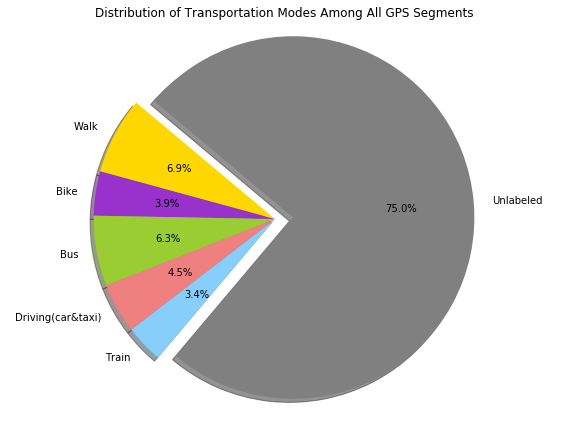

In [3]:
# After converting the raw GPS trajectories into the image-like GPS tensors, the proportion of GPS segments for each mode among 
# labeled trajectories and the proportion of unlabled GPS segments are shown in the pie chart. 

import numpy as np
import pickle
import matplotlib.pyplot as plt

# Import train, validation, and test image-like GPS segments
filename = '../Mode-codes-Revised/paper2_data_for_DL_train_val_test.pickle'
# Codes for computing datasets in the pickle are coming after this plot cell.
with open(filename, 'rb') as f:
    Train_X, Train_Y, Val_X, Val_Y, Val_Y_ori, Test_X, Test_Y, Test_Y_ori, X_unlabeled = pickle.load(f)

# Sum the number of GPS segments for each mode and number of unlabeled trajectories. 
num_labels = 5
mode_distribution = []
Train_Y_ori = np.argmax(Train_Y, axis=1)
for i in range(num_labels):
    mode_distribution.append(len(np.where(Train_Y_ori == i)[0]) + len(np.where(Val_Y_ori == i)[0])
                             + len(np.where(Test_Y_ori == i)[0]))
mode_distribution.append(len(X_unlabeled))

# Plot pie chart for mode distribution
labels = 'Walk', 'Bike', 'Bus', 'Driving(car&taxi)', 'Train', 'Unlabeled'
sizes = mode_distribution
colors = ['gold', 'darkorchid', 'yellowgreen', 'lightcoral', 'lightskyblue', 'gray']
explode = (0, 0, 0, 0, 0, 0.1)

plt.figure(1, figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Transportation Modes Among All GPS Segments')
plt.tight_layout()
plt.show()

In [ ]:
import pickle
from datetime import datetime
import os
import time
start_time = time.clock()


def days_date(time_str):
    date_format = "%Y/%m/%d %H:%M:%S"
    current = datetime.strptime(time_str, date_format)
    date_format = "%Y/%m/%d"
    bench = datetime.strptime('1899/12/30', date_format)
    no_days = current - bench
    delta_time_days = no_days.days + current.hour / 24.0 + current.minute / (24. * 60.) + current.second / (24. * 3600.)
    return delta_time_days

# Change Mode Name to Mode index
Mode_Index = {"walk": 0, "run": 9, "bike": 1, "bus": 2, "car": 3, "taxi": 3, "subway": 4, "railway": 4,
              "train": 4, "motocycle": 8, "boat": 9, "airplane": 9, "other": 9}

# Ground modes are the modes that we use in this paper.
Ground_Mode = ['walk', 'bike', 'bus', 'car', 'taxi', 'subway', 'railway', 'train']

# The Geolife Trajectories 1.3 has been directly downloaded from the source. Link is provided in the submission page. 
geolife_dir = '../Geolife Trajectories 1.3-Raw-All/Geolife Trajectories 1.3/Data/'
users_folder = os.listdir(geolife_dir)
trajectory_all_user_wo_label = []
trajectory_all_user_with_label = []
label_all_user = []
for folder in users_folder:
    if len(os.listdir(geolife_dir + folder)) == 1:
        trajectory_dir = geolife_dir + folder + '/Trajectory/'
        user_trajectories = os.listdir(trajectory_dir)
        trajectory_one_user = []
        for plt in user_trajectories:
            with open(trajectory_dir + plt, 'r', newline='', encoding='utf-8') as f:
                GPS_logs = filter(lambda x: len(x.split(',')) == 7, f)
                GPS_logs_split = map(lambda x: x.rstrip('\r\n').split(','), GPS_logs)
                for row in GPS_logs_split:
                    trajectory_one_user.append([float(row[0]), float(row[1]), float(row[4])])
        trajectory_all_user_wo_label.append(trajectory_one_user)

    elif len(os.listdir(geolife_dir + folder)) == 2:
        trajectory_dir = geolife_dir + folder + '/Trajectory/'
        user_trajectories = os.listdir(trajectory_dir)
        trajectory_one_user = []
        for plt in user_trajectories:
            with open(trajectory_dir + plt, 'r', newline='', encoding='utf-8') as f:
                GPS_logs = filter(lambda x: len(x.split(',')) == 7, f)
                GPS_logs_split = map(lambda x: x.rstrip('\r\n').split(','), GPS_logs)
                for row in GPS_logs_split:
                    trajectory_one_user.append([float(row[0]), float(row[1]), float(row[4])])
        trajectory_all_user_with_label.append(trajectory_one_user)

        label_dir = geolife_dir + folder + '/labels.txt'
        with open(label_dir, 'r', newline='', encoding='utf-8') as f:
            label = list(map(lambda x: x.rstrip('\r\n').split('\t'), f))
            label_filter = list(filter(lambda x: len(x) == 3 and x[2] in Ground_Mode, label))
            label_one_user = []
            for row in label_filter:
                label_one_user.append([days_date(row[0]), days_date(row[1]), Mode_Index[row[2]]])
        label_all_user.append(label_one_user)

trajectory_all_user_with_label_Final = []  # Only contain users' trajectories that have labels
for index, user in enumerate(label_all_user):
    trajectory_user = trajectory_all_user_with_label[index]
    classes = {0: [], 1: [], 2: [], 3: [], 4: []}
    start_index = 0
    for row in user:
        if not trajectory_user:
            break

        start = row[0]
        end = row[1]
        mode = row[2]

        if trajectory_user[0][2] > end or trajectory_user[-1][2] < start:
            continue

        for index1, trajectory in enumerate(trajectory_user):
            if start <= trajectory[2] <= end:
                start_index += index1
                trajectory_user = trajectory_user[index1 + 1:]
                break

        if trajectory_user[-1][2] < end:
            end_index = start_index + 1 + len(trajectory_user)
            classes[mode].extend(list(range(start_index, end_index)))
            break
        else:
            for index2, trajectory in enumerate(trajectory_user):
                if trajectory[2] > end:
                    end_index = start_index + 1 + index2
                    trajectory_user = trajectory_user[index2 + 1:]
                    classes[mode].extend(list(range(start_index, end_index)))
                    start_index = end_index + 1
                    break

    for k, v in classes.items():
        for value in v:
            trajectory_all_user_with_label[index][value].append(k)
    labeled_trajectory = list(filter(lambda x: len(x) == 4, trajectory_all_user_with_label[index]))
    trajectory_all_user_with_label_Final.append(labeled_trajectory)
    unlabeled_trajectory = list(filter(lambda x: len(x) == 3, trajectory_all_user_with_label[index]))
    trajectory_all_user_wo_label.append(unlabeled_trajectory)

# Save Trajectory_Array and Label_Array for all users
with open("paper2_Trajectory_Label.pickle", 'wb') as f:
    pickle.dump([trajectory_all_user_with_label_Final, trajectory_all_user_wo_label], f)

print(time.clock() - start_time, 'Seconds')


In [ ]:
import numpy as np
import pickle
from geopy.distance import vincenty
import math
import time
import random
import pandas as pd

# Change the current working directory to the location of 'Combined Trajectory_Label_Geolife' folder.
current = time.clock()
min_threshold = 20
max_threshold = 248
min_distance = 150
min_time = 60


filename = '../Mode-codes-Revised/paper2_Trajectory_Label.pickle'
with open(filename, 'rb') as f:
    trajectory_all_user_with_label, trajectory_all_user_wo_label = pickle.load(f)


# trajectory_all_user_with_label = trajectory_all_user_with_label[:2]
# trajectory_all_user_wo_label = trajectory_all_user_wo_label[:2]


# Identify the Speed and Acceleration limit
SpeedLimit = {0: 7, 1: 12, 2: 120./3.6, 3: 180./3.6, 4: 120/3.6}
# Online sources for Acc: walk: 1.5 Train 1.15, bus. 1.25 (.2), bike: 2.6, train:1.5
AccLimit = {0: 3, 1: 3, 2: 2, 3: 10, 4: 3}


def unlabeled_gps_to_trip(trajectory_one_user, trip_time):
    """
    This function divide total GPS trajectory of one user into some trips, when the travel time between two consecutive
    GPS points exceeds the "trip time". Also, remove the erroneous GPS points that their travel time is non-positive.
    :param trajectory_one_user: A sequence of a users' all GPS points.
    :param trip_time: the maximum time for dividing a GPS sequence into trips.
    :return: a user's  trips
    """
    trip = []
    all_trip_one_user = []
    i = 0
    while i < len(trajectory_one_user) - 1:
        delta_time = (trajectory_one_user[i+1][2] - trajectory_one_user[i][2]) * 24 * 3600
        if 0 < delta_time <= trip_time:
            trip.append(trajectory_one_user[i])
            i += 1
        elif delta_time > trip_time:
            trip.append(trajectory_one_user[i])
            all_trip_one_user.append(trip)
            trip = []
            i += 1
        else:
            trajectory_one_user.remove(trajectory_one_user[i + 1])
    return all_trip_one_user


def labeled_gps_to_trip(trajectory_one_user, trip_time):
    """
    This function divides total labeled-GPS trajectory of one user into some trips, when either the travel time between
    two consecutive GPS points exceeds the "trip time" or the mode changes.
    Also, remove the erroneous GPS points that their travel time is non-positive.
    :param trajectory_one_user: A sequence of a users' all GPS points.
    :param trip_time: the maximum time for dividing a GPS sequence into trips.
    :return: a user's  trips
    """
    trip = []
    all_trip_one_user = []
    i = 0
    while i < len(trajectory_one_user) - 1:
        delta_time = (trajectory_one_user[i+1][2] - trajectory_one_user[i][2]) * 24 * 3600
        mode_not_change = (trajectory_one_user[i+1][3] == trajectory_one_user[i][3])
        if 0 < delta_time <= trip_time and mode_not_change:
            trip.append(trajectory_one_user[i])
            i += 1
        elif delta_time > trip_time or not mode_not_change:
            trip.append(trajectory_one_user[i])
            all_trip_one_user.append(trip)
            trip = []
            i += 1
        elif delta_time <= 0:
            trajectory_one_user.remove(trajectory_one_user[i + 1])
    return all_trip_one_user

# The two following lists contain all trips of all users.
trip_all_user_with_label = [labeled_gps_to_trip(trajectory, trip_time=20*60) for trajectory in
                            trajectory_all_user_with_label]
trip_all_user_wo_label = [unlabeled_gps_to_trip(trajectory, trip_time=20*60) for trajectory in
                          trajectory_all_user_wo_label]


def compute_delta_time(p1, p2):
    """
    :param p2: trajectory_one_user[i + 1]
    :param p1: trajectory_one_user[i]
    :return:
    """
    return (p2[2] - p1[2]) * 24 * 3600


def compute_distance(p1, p2):
    lat_long_1 = (p1[0], p1[1])
    lat_long_2 = (p2[0], p2[1])
    return vincenty(lat_long_1, lat_long_2).meters


def compute_speed(distance, delta_time):
    return distance/delta_time


def compute_acceleration(speed1, speed2, delta_time):
    return (speed2 - speed1) / delta_time


def compute_jerk(acc1, acc2, delta_time):
    return (acc2 - acc1) / delta_time


def compute_bearing(p1, p2):
    y = math.sin(math.radians(p2[1]) - math.radians(p1[1])) * math.radians(math.cos(p2[0]))
    x = math.radians(math.cos(p1[0])) * math.radians(math.sin(p2[0])) - \
        math.radians(math.sin(p1[0])) * math.radians(math.cos(p2[0])) \
        * math.radians(math.cos(p2[1]) - math.radians(p1[1]))
    # Convert radian from -pi to pi to [0, 360] degree
    return (math.atan2(y, x) * 180. / math.pi + 360) % 360


def compute_bearing_rate(bearing1, bearing2):
    return abs(bearing1 - bearing2)


def remove_error_labeled(trip_motion_features, mode):
    outlier_speed = [index for index, item in enumerate(trip_motion_features[3]) if item > SpeedLimit[mode]]
    outlier_acc = [index for index, item in enumerate(trip_motion_features[4]) if
                   abs(item) > AccLimit[mode] and index not in outlier_speed]
    outlier = outlier_speed + outlier_acc
    trip_motion_features = np.delete(np.array(trip_motion_features), outlier, axis=1)
    return trip_motion_features


def remove_error_unlabeled(trip_motion_features):
    speed = trip_motion_features[3]
    upper_quartile = np.percentile(speed, 75)
    lower_quartile = np.percentile(speed, 25)
    iqr = (upper_quartile - lower_quartile) * 1.5
    quartile_set = (max(lower_quartile - iqr, 0), min(upper_quartile + iqr, 50))
    outlier_speed = [index for index, item in enumerate(speed) if item < quartile_set[0] or
                     item > quartile_set[1]]
    acc = trip_motion_features[4]
    upper_quartile = np.percentile(acc, 75)
    lower_quartile = np.percentile(acc, 25)
    iqr = (upper_quartile - lower_quartile) * 1.5
    quartile_set = (max(lower_quartile - iqr, -10), min(upper_quartile + iqr, 10))
    outlier_acc = [index for index, item in enumerate(acc) if
                   (item < quartile_set[0] or item > quartile_set[1]) and index not in outlier_speed]
    outlier = outlier_speed + outlier_acc
    trip_motion_features = np.delete(np.array(trip_motion_features), outlier, axis=1)
    return trip_motion_features


def compute_trip_motion_features(all_trip_one_user, data_type):
    """
    This function computes the motion features for every trip (i.e., a sequence of GPS points).
    There are four types of motion features: speed, acceleration, jerk, and bearing rate.
    :param trip: a sequence of GPS points
    :param data_type: is it related to a 'labeled' and 'unlabeled' data set.
    :return: A list with four sub-lists, where every sub-list is a motion feature.
    """
    all_trip_motion_features_one_user = []
    for trip in all_trip_one_user:
        if len(trip) >= 4:
            relative_distance = []
            delta_time = []
            relative_speed = []
            speed = []
            acc = []
            jerk = []
            bearing_rate = []
            delta_time_1 = compute_delta_time(trip[0], trip[1])
            distance_1 = compute_distance(trip[0], trip[1])
            speed1 = compute_speed(distance_1, delta_time_1)
            delta_time_2 = compute_delta_time(trip[1], trip[2])
            distance_2 = compute_distance(trip[1], trip[2])
            speed2 = compute_speed(distance_2, delta_time_2)
            acc1 = compute_acceleration(speed1, speed2, delta_time_1)
            for i in range(len(trip) - 3):
                delta_time_1 = compute_delta_time(trip[i], trip[i + 1])
                delta_time_3 = compute_delta_time(trip[i + 2], trip[i + 3])
                distance_3 = compute_distance(trip[i + 2], trip[i + 3])
                speed3 = compute_speed(distance_3, delta_time_3)
                acc2 = compute_acceleration(speed2, speed3, delta_time_2)
                relative_distance.append(distance_1)
                delta_time.append(delta_time_1)
                relative_speed.append(abs((speed2 - speed1)) / speed1 if speed1 != 0 else 0)
                speed.append(speed1)
                acc.append(acc1)
                jerk.append(compute_jerk(acc1, acc2, delta_time=delta_time_1))
                bearing_rate.append(compute_bearing_rate(compute_bearing(trip[i], trip[i + 1]),
                                                         compute_bearing(trip[i + 1], trip[i + 2])))
                delta_time_2 = delta_time_3
                distance_1 = distance_2
                distance_2 = distance_3
                speed1 = speed2
                speed2 = speed3
                acc1 = acc2
            trip_motion_features = [relative_distance, delta_time, relative_speed, speed, acc, jerk, bearing_rate]
            if data_type == 'labeled':
                mode = trip[0][3]
                # Randomly check that all trip[i][3] have the same mode
                assert trip[0][3] == trip[np.random.randint(1, len(trip)-1, 1)[0]][3]
                trip_motion_features = remove_error_labeled(trip_motion_features, mode)
                all_trip_motion_features_one_user.append((trip_motion_features, mode))
            if data_type == 'unlabeled':
                trip_motion_features = remove_error_unlabeled(trip_motion_features)
                all_trip_motion_features_one_user.append(trip_motion_features)
    return all_trip_motion_features_one_user

trip_motion_all_user_with_label = [compute_trip_motion_features(user, data_type='labeled') for user
                                   in trip_all_user_with_label]
trip_motion_all_user_wo_label = [compute_trip_motion_features(user, data_type='unlabeled') for user
                                 in trip_all_user_wo_label]

# This pickling and unpickling is due to large computation time before this line.
with open('paper2_trips_motion_features_temp.pickle', 'wb') as f:
    pickle.dump([trip_motion_all_user_with_label, trip_motion_all_user_wo_label], f)


filename = '../Mode-codes-Revised/paper2_trips_motion_features_temp.pickle'
with open(filename, 'rb') as f:
    trip_motion_all_user_with_label, trip_motion_all_user_wo_label = pickle.load(f)


def trip_check_thresholds(trip_motion_all_user, min_threshold, min_distance, min_time, data_type):
    # Remove trip with less than a min GPS point, less than a min-distance, less than a min trip time.
    all_user = []
    if data_type == 'labeled':
        for user in trip_motion_all_user:
            all_user.append(list(filter(lambda trip: len(trip[0][0]) >= min_threshold and np.sum(trip[0][0, :]) >= min_distance
                                          and np.sum(trip[0][1, :]) >= min_time, user)))
    if data_type == 'unlabeled':
        for user in trip_motion_all_user:
            all_user.append(list(filter(lambda trip: len(trip[0]) >= min_threshold and np.sum(trip[0, :]) >= min_distance
                                          and np.sum(trip[1, :]) >= min_time, user)))
    return all_user
# Split the trips for each user into train, test, and validation sets.
trip_motion_all_user_with_label = trip_check_thresholds(trip_motion_all_user_with_label, min_threshold=min_threshold, min_distance=min_distance, min_time=min_time,
                                                        data_type='labeled')
trip_motion_all_user_wo_label = trip_check_thresholds(trip_motion_all_user_wo_label, min_threshold=min_threshold, min_distance=min_distance, min_time=min_time,
                                                        data_type='unlabeled')

trip_length_labeled = [len(trip[0][0]) for user in trip_motion_all_user_with_label for trip in user]
trip_length_unlabeled = [len(trip[0]) for user in trip_motion_all_user_wo_label for trip in user]

print('Descriptive statistics for labeled',  pd.Series(trip_length_labeled).describe(percentiles=[0.05, 0.1, 0.15,
                                                                                                      0.25, 0.5, 0.75,
                                                                                                      0.85, 0.9, 0.95]))
print('Descriptive statistics for unlabeled',  pd.Series(trip_length_unlabeled).describe(percentiles=[0.05, 0.1, 0.15,
                                                                                                      0.25, 0.5, 0.75,
                                                                                                      0.85, 0.9, 0.95]))

# Now, we have all trips in a list from all users. So time to Create train, test, and validation sets
train_trip_motion_all_user_with_label = []
val_trip_motion_all_user_with_label = []
test_trip_motion_all_user_with_label = []
for user in trip_motion_all_user_with_label:
    random.shuffle(user)
    length = len(user)
    train_trip_motion_all_user_with_label.extend(user[:round(0.7*length)])
    val_trip_motion_all_user_with_label.extend(user[round(0.7*length):round(0.8*length)])
    test_trip_motion_all_user_with_label.extend(user[round(0.8*length):])

trip_motion_all_user_wo_label = [trip for user in trip_motion_all_user_wo_label for trip in user]

with open('paper2_trips_motion_features_NotFixedLength_woOutliers.pickle', 'wb') as f:
    pickle.dump([train_trip_motion_all_user_with_label, val_trip_motion_all_user_with_label,
                 test_trip_motion_all_user_with_label, trip_motion_all_user_wo_label], f)

print('Running time', time.clock() - current)


In [ ]:
import numpy as np
import pickle
import keras

# Import the final output from Instance_creation file, which is the filtered trips for all users.

filename = '../Mode-codes-Revised/paper2_trips_motion_features_NotFixedLength_woOutliers.pickle'
with open(filename, 'rb') as f:
    train_trip_motion_all_user_with_label, val_trip_motion_all_user_with_label, \
    test_trip_motion_all_user_with_label, trip_motion_all_user_wo_label = pickle.load(f)


# Apply some of data preprocessing step in the paper and prepare the final input layer for deep learning

# Settings
# AccLimit = {0: 3, 1: 3, 2: 2, 3: 10, 4: 3}
min_threshold = 20
max_threshold = 248
min_distance = 150  # Meters
min_time = 60  # Seconds
num_class = 5
new_channel = 4
min_percentile = 0
max_percentile = 100


def take_speed_percentile(trip, min_percentile, max_percentile):
    min_threshold = np.percentile(trip[1], min_percentile)
    max_threshold = np.percentile(trip[1], max_percentile)
    index_min = np.where(trip[1] >= min_threshold)[0]
    index_max = np.where(trip[1] <= max_threshold)[0]
    index = np.intersect1d(index_min, index_max)
    trip = trip[:, index]
    return trip


def trip_to_fixed_length(trip_motion_all_user, min_threshold, max_threshold, min_distance, min_time, data_type):
    if data_type == 'labeled':
        total_input = []
        total_label = []
        for index, trip in enumerate(trip_motion_all_user):
            trip, mode = trip
            trip = take_speed_percentile(trip, min_percentile=min_percentile, max_percentile=max_percentile)
            trip_length = len(trip[0])
            if all([trip_length >= min_threshold, trip_length < max_threshold, np.sum(trip[0, :]) >= min_distance,
                    np.sum(trip[1, :]) >= min_time]):
                trip_padded = np.pad(trip, ((0, 0), (0, max_threshold - trip_length)), 'constant')
                total_input.append(trip_padded)
                total_label.append(mode)
            elif trip_length >= max_threshold:
                    quotient = trip_length // max_threshold
                    for i in range(quotient):
                        trip_truncated = trip[:, i * max_threshold:(i + 1) * max_threshold]
                        if all([np.sum(trip_truncated[0, :]) >= min_distance, np.sum(trip_truncated[1, :]) >= min_time]):
                            total_input.append(trip_truncated)
                            total_label.append(mode)
                    remain_trip = trip[:, (i + 1) * max_threshold:]
                    if all([(trip_length % max_threshold) > min_threshold, np.sum(remain_trip[0, :]) >= min_distance,
                            np.sum(remain_trip[1, :]) >= min_time]):
                        trip_padded = np.pad(remain_trip, ((0, 0), (0, max_threshold - trip_length % max_threshold)),
                                             'constant')
                        total_input.append(trip_padded)
                        total_label.append(mode)

        return np.array(total_input), np.array(total_label)

    elif data_type == 'unlabeled':
        total_input = []
        for index, trip in enumerate(trip_motion_all_user):
            trip_length = len(trip[0])
            if all([trip_length >= min_threshold, trip_length < max_threshold, np.sum(trip[0, :]) >= min_distance,
                    np.sum(trip[1, :]) >= min_time]):
                trip_padded = np.pad(trip, ((0, 0), (0, max_threshold - trip_length)), 'constant')
                total_input.append(trip_padded)
            elif trip_length >= max_threshold:
                quotient = trip_length // max_threshold
                for i in range(quotient):
                    trip_truncated = trip[:, i * max_threshold:(i + 1) * max_threshold]
                    if all([np.sum(trip_truncated[0, :]) >= min_distance, np.sum(trip_truncated[1, :]) >= min_time]):
                        total_input.append(trip_truncated)
                remain_trip = trip[:, (i + 1) * max_threshold:]
                if all([trip_length % max_threshold > min_threshold, np.sum(remain_trip[0, :]) >= min_distance,
                        np.sum(remain_trip[1, :]) >= min_time]):
                    trip_padded = np.pad(remain_trip, ((0, 0), (0, max_threshold - trip_length % max_threshold)),
                                         'constant')
                    total_input.append(trip_padded)
        return np.array(total_input)

# Max_threshold=200: 200 is the rounded median size of all trips (i.e., GPS trajectory) after removing errors and
# outliers including: 1) max speed and acceleration, (2) trip length less than 10
Train_X, Train_Y = trip_to_fixed_length(train_trip_motion_all_user_with_label, min_threshold=min_threshold,
                                                                max_threshold=max_threshold, min_distance=min_distance, min_time=min_time,
                                                                data_type='labeled')
Val_X, Val_Y_ori = trip_to_fixed_length(val_trip_motion_all_user_with_label, min_threshold=min_threshold,
                                                                max_threshold=max_threshold, min_distance=min_distance, min_time=min_time,
                                                                data_type='labeled')
Test_X, Test_Y_ori = trip_to_fixed_length(test_trip_motion_all_user_with_label, min_threshold=min_threshold,
                                                                max_threshold=max_threshold, min_distance=min_distance, min_time=min_time,
                                                                data_type='labeled')
X_unlabeled = trip_to_fixed_length(trip_motion_all_user_wo_label, min_threshold=min_threshold,
                                             max_threshold=max_threshold, min_distance=min_distance, min_time=min_time, data_type='unlabeled')


def change_to_new_channel(input):
    input = input[:, 3:, :]
    total_input_new = np.zeros((len(input), 1, max_threshold, new_channel))
    for i in range(len(input)):
        total_input_new[i, 0, :, 0] = input[i, 0, :]
        total_input_new[i, 0, :, 1] = input[i, 1, :]
        total_input_new[i, 0, :, 2] = input[i, 2, :]
        total_input_new[i, 0, :, 3] = input[i, 3, :]
    return total_input_new

Train_X = change_to_new_channel(Train_X)
Train_Y = keras.utils.to_categorical(Train_Y, num_classes=num_class)
Val_X = change_to_new_channel(Val_X)
Val_Y = keras.utils.to_categorical(Val_Y_ori, num_classes=num_class)
Test_X = change_to_new_channel(Test_X)
Test_Y = keras.utils.to_categorical(Test_Y_ori, num_classes=num_class)
X_unlabeled = change_to_new_channel(X_unlabeled)


def min_max_scaler(input, min, max):
    """
    Min_max scaling of each channel.
    :param input:
    :param min:
    :param max:
    :return:
    """
    current_minmax = [(np.min(input[:, :, :, i]), np.max(input[:, :, :, i])) for i in range(new_channel)]
    for index, item in enumerate(current_minmax):
        input[:, :, :, index] = (input[:, :, :, index] - item[0])/(item[1] - item[0]) * (max - min) + min
    return input, current_minmax
# Min_max scaling
Train_X, current_minmax = min_max_scaler(Train_X, 0, 1)
for index, item in enumerate(current_minmax):
    Test_X[:, :, :, index] = (Test_X[:, :, :, index] - item[0]) / (item[1] - item[0])
    Val_X[:, :, :, index] = (Val_X[:, :, :, index] - item[0]) / (item[1] - item[0])
X_unlabeled, _ = min_max_scaler(X_unlabeled, 0, 1)

with open('paper2_data_for_DL_train_val_test.pickle', 'wb') as f:
    pickle.dump([Train_X, Train_Y, Val_X, Val_Y, Val_Y_ori, Test_X, Test_Y, Test_Y_ori, X_unlabeled], f)
